# Chess Deep Learning Agent: Benchmarks and Analysis

Run matches against baseline engines and analyze results.

In [1]:
import sys
sys.path.append('../src')

import torch
import json
import chess.pgn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from model.nets import MiniResNetPolicyValue
from search.alphabeta import AlphaBetaSearcher, SearchConfig
from play.stockfish_wrapper import StockfishWrapper
from play.sunfish_wrapper import SunfishWrapper
from play.opening_book import OpeningBook
from play.match_runner_enhanced import EnhancedMatchRunner
from utils.metrics import calculate_elo_difference
from utils.plotting import plot_match_results

WEIGHTS_DIR = Path('../artifacts/weights')
MATCHES_DIR = Path('../artifacts/matches')
MATCHES_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR = Path('../reports/figures')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


## Setup Validation

Validate the environment before running long benchmarks.

In [2]:
# Validation: Check that MatchStatistics has correct attributes
# This prevents wasting time on long-running benchmarks that will fail
from dataclasses import fields
from play.match_runner_enhanced import MatchStatistics

print("Validating MatchStatistics dataclass...")
required_attrs = ['total_games', 'wins', 'draws', 'losses', 'score', 'win_rate',
                  'avg_moves', 'avg_duration', 'elo_estimate', 'elo_ci_lower',
                  'elo_ci_upper', 'avg_acpl']

field_names = [f.name for f in fields(MatchStatistics)]

print(f"Expected attributes: {required_attrs}")
print(f"Actual attributes:   {field_names}")

missing = set(required_attrs) - set(field_names)
if missing:
    raise AttributeError(f"MatchStatistics is missing attributes: {missing}")

# Verify no old cached attributes exist
old_attrs = ['elo_upper', 'elo_lower']  # These should NOT exist
for attr in old_attrs:
    if attr in field_names:
        raise AttributeError(f"MatchStatistics has deprecated attribute: {attr}")

print("✓ Validation passed! MatchStatistics has correct attributes.")
print("✓ Safe to run benchmarks.")

Validating MatchStatistics dataclass...
Expected attributes: ['total_games', 'wins', 'draws', 'losses', 'score', 'win_rate', 'avg_moves', 'avg_duration', 'elo_estimate', 'elo_ci_lower', 'elo_ci_upper', 'avg_acpl']
Actual attributes:   ['total_games', 'wins', 'draws', 'losses', 'score', 'win_rate', 'avg_moves', 'avg_duration', 'elo_estimate', 'elo_ci_lower', 'elo_ci_upper', 'avg_acpl']
✓ Validation passed! MatchStatistics has correct attributes.
✓ Safe to run benchmarks.


## Load Trained Model

In [3]:
# Load trained model
model = MiniResNetPolicyValue(num_blocks=6, channels=64)
model.load_state_dict(torch.load(WEIGHTS_DIR / 'best_model.pth', map_location=device))
model = model.to(device)
model.eval()

print("✓ Model loaded successfully")
print(f"  Parameters: {model.count_parameters():,}")

# Load opening book
opening_book = OpeningBook()
print(f"✓ Opening book loaded: {len(opening_book)} lines")

# Create search configuration with enhanced features
search_config = SearchConfig(
    max_depth=3,
    movetime=0.3,  # 300ms per move
    use_policy_ordering=True,
    use_value_eval=True,
    enable_quiescence=True,
    quiescence_depth=2,
    use_transposition_table=True,
    tt_size=100000,
)

print("✓ Search configuration:")
print(f"  Max depth: {search_config.max_depth}")
print(f"  Movetime: {search_config.movetime}s")
print(f"  Quiescence: {search_config.enable_quiescence}")
print(f"  Transposition table: {search_config.use_transposition_table}")

# Create agent wrapper
class AgentWrapper:
    def __init__(self, model, device, config):
        self.searcher = AlphaBetaSearcher(model, device, config)
        self.name = "ChessAgent-ResNet6x64"

    def get_move(self, board):
        move, score = self.searcher.search(board)
        return move

    def get_name(self):
        return self.name

our_agent = AgentWrapper(model, device, search_config)
print(f"✓ Agent ready: {our_agent.get_name()}")

✓ Model loaded successfully
  Parameters: 5,995,265
✓ Opening book loaded: 21 lines
✓ Search configuration:
  Max depth: 3
  Movetime: 0.3s
  Quiescence: True
  Transposition table: True
✓ Agent ready: ChessAgent-ResNet6x64


## Match 1: vs Sunfish

In [4]:
# Configuration
NUM_GAMES = 100  # Set to 100-300 for comprehensive benchmarks

print(f"Running benchmark: {NUM_GAMES} games vs Sunfish")

# Create opponent
sunfish = SunfishWrapper(depth=2)

# Run match with enhanced runner
runner = EnhancedMatchRunner(
    our_agent,
    sunfish,
    MATCHES_DIR,
    opening_book=opening_book,
    compute_acpl=False,  # Set True if you want ACPL analysis (slower)
)

stats_sunfish = runner.run_match(num_games=NUM_GAMES, alternate_colors=True)

# Print detailed summary
runner.print_summary(our_agent.get_name())

Running benchmark: 100 games vs Sunfish

Starting match: ChessAgent-ResNet6x64 vs Sunfish-D2
Games: 100, Alternate colors: True



Playing games: 100%|██████████| 100/100 [46:01<00:00, 27.61s/it]


Saved PGNs to: ../artifacts/matches/match_ChessAgent-ResNet6x64_vs_Sunfish-D2_20251027_193911.pgn
Saved statistics to: ../artifacts/matches/match_ChessAgent-ResNet6x64_vs_Sunfish-D2_20251027_193911.json

Match Summary: ChessAgent-ResNet6x64
Total Games:     100
Wins:            45
Draws:           36
Losses:          19
Score:           63.0 / 100 (63.0%)
Elo Estimate:    +92 ± 76
Elo 95% CI:      [25, 168]
Avg Moves:       119.1
Avg Duration:    27.60s



## Match 2: vs Stockfish (Limited Strength)

In [5]:
# Check if Stockfish is available
STOCKFISH_PATH = '/opt/homebrew/bin/stockfish'  # macOS Homebrew path
ALT_PATH = '/usr/local/bin/stockfish'  # Alternative path

# Try to find Stockfish
if not Path(STOCKFISH_PATH).exists():
    STOCKFISH_PATH = ALT_PATH

if Path(STOCKFISH_PATH).exists():
    print(f"Running benchmark: {NUM_GAMES} games vs Stockfish Level 1")

    # Create limited-strength Stockfish
    with StockfishWrapper(STOCKFISH_PATH, skill_level=1, time_limit=0.3) as stockfish:
        runner = EnhancedMatchRunner(
            our_agent,
            stockfish,
            MATCHES_DIR,
            opening_book=opening_book,
            compute_acpl=False,
        )
        stats_stockfish = runner.run_match(num_games=NUM_GAMES, alternate_colors=True)

    runner.print_summary(our_agent.get_name())
else:
    print(f"⚠ Stockfish not found at {STOCKFISH_PATH}")
    print("Install with: brew install stockfish (macOS)")
    stats_stockfish = None

Running benchmark: 100 games vs Stockfish Level 1

Starting match: ChessAgent-ResNet6x64 vs Stockfish-Lv1
Games: 100, Alternate colors: True



Playing games: 100%|██████████| 100/100 [53:26<00:00, 32.07s/it]


Saved PGNs to: ../artifacts/matches/match_ChessAgent-ResNet6x64_vs_Stockfish-Lv1_20251027_203239.pgn
Saved statistics to: ../artifacts/matches/match_ChessAgent-ResNet6x64_vs_Stockfish-Lv1_20251027_203239.json

Match Summary: ChessAgent-ResNet6x64
Total Games:     100
Wins:            12
Draws:           6
Losses:          82
Score:           15.0 / 100 (15.0%)
Elo Estimate:    -301 ± 81
Elo 95% CI:      [-424, -220]
Avg Moves:       95.4
Avg Duration:    32.06s



## Match 3: vs Maia (Lc0 with Human-Like Weights)

Benchmark against Maia, a human-like chess engine based on Lc0.

**Requirements:**
- Lc0 binary installed (`brew install lc0` on macOS)
- Maia weights downloaded from https://maiachess.com/

In [6]:
# Maia Sanity Check
print("=" * 70)
print("MAIA SANITY CHECK")
print("=" * 70)

# Configuration - Updated for your installation
LCO_PATH = '/usr/local/bin/lc0'
MAIA_WEIGHTS = '../weights/maia-1500.pb.gz'

NUM_GAMES = 100

# Check if Lc0 and weights are available
if Path(LCO_PATH).exists() and Path(MAIA_WEIGHTS).exists():
    print(f"✓ Lc0 found at: {LCO_PATH}")
    print(f"✓ Maia weights found at: {MAIA_WEIGHTS}")

    # Run sanity check
    from play.sanity import sanity_check_maia

    try:
        results = sanity_check_maia(
            lc0_path=LCO_PATH,
            weights_path=MAIA_WEIGHTS,
            threads=1,
            movetime_ms=200,
        )

        print("\n✓ Sanity check passed!")
        print(f"  Start position reply: {results['start_reply']}")
        print(f"  Reply to e2e4: {results['reply_to_e4']}")

        maia_available = True

    except Exception as e:
        print(f"\n✗ Sanity check failed: {e}")
        print("  Maia benchmarking will be skipped.")
        maia_available = False

else:
    print("✗ Maia not available:")
    if not Path(LCO_PATH).exists():
        print(f"  - Lc0 not found at {LCO_PATH}")
        print("    Install: brew install lc0 (macOS)")
    if not Path(MAIA_WEIGHTS).exists():
        print(f"  - Weights not found at {MAIA_WEIGHTS}")
        print("    Download from: https://maiachess.com/")

    maia_available = False

print("=" * 70)

MAIA SANITY CHECK
✓ Lc0 found at: /usr/local/bin/lc0
✓ Maia weights found at: ../weights/maia-1500.pb.gz
MAIA SANITY CHECK
Lc0 path: /usr/local/bin/lc0
Weights: ../weights/maia-1500.pb.gz
Threads: 1
Movetime: 200ms

[1/3] Starting Maia engine...
      ✓ Engine started: Maia-maia-1500

[2/3] Test 1: Move from starting position
      FEN: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
      Requesting move...
      Move: e2e4
      ✓ Move is legal

[3/3] Test 2: Reply to e2e4
      We play: e2e4
      FEN: rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
      Requesting Maia's reply...
      Reply: e7e5
      ✓ Reply is legal

[Cleanup] Shutting down engine...
          ✓ Engine shut down

SANITY CHECK PASSED
Start position reply: e2e4
Reply to e2e4:        e7e5

✓ Sanity check passed!
  Start position reply: e2e4
  Reply to e2e4: e7e5


In [7]:
# Run Maia Benchmark (if available)
if maia_available:
    print(f"\nRunning benchmark: {NUM_GAMES} games vs Maia-1500")

    from play.maia_lc0_wrapper import MaiaLc0Engine

    try:
        with MaiaLc0Engine(
            lc0_path=LCO_PATH,
            weights_path=MAIA_WEIGHTS,
            movetime_ms=300,
            threads=1,
        ) as maia:
            runner = EnhancedMatchRunner(
                our_agent,
                maia,
                MATCHES_DIR,
                opening_book=opening_book,
                compute_acpl=False,
            )
            stats_maia = runner.run_match(num_games=NUM_GAMES, alternate_colors=True)

        runner.print_summary(our_agent.get_name())
        print("✓ Maia benchmark complete")

    except Exception as e:
        print(f"✗ Maia benchmark failed: {e}")
        stats_maia = None

else:
    print("\nSkipping Maia benchmark (not available)")
    stats_maia = None


Running benchmark: 100 games vs Maia-1500

Starting match: ChessAgent-ResNet6x64 vs Maia-maia-1500
Games: 100, Alternate colors: True



Playing games: 100%|██████████| 100/100 [29:52<00:00, 17.92s/it]



Saved PGNs to: ../artifacts/matches/match_ChessAgent-ResNet6x64_vs_Maia-maia-1500_20251027_210232.pgn
Saved statistics to: ../artifacts/matches/match_ChessAgent-ResNet6x64_vs_Maia-maia-1500_20251027_210232.json

Match Summary: ChessAgent-ResNet6x64
Total Games:     100
Wins:            1
Draws:           2
Losses:          97
Score:           2.0 / 100 (2.0%)
Elo Estimate:    -676 ± 155
Elo 95% CI:      [-798, -521]
Avg Moves:       72.3
Avg Duration:    17.92s

✓ Maia benchmark complete


# Collect all benchmark results
results = {}

if 'stats_sunfish' in locals() and stats_sunfish:
    results['Sunfish (D2)'] = stats_sunfish

if 'stats_stockfish' in locals() and stats_stockfish:
    results['Stockfish (Lv1)'] = stats_stockfish

if 'stats_maia' in locals() and stats_maia:
    results['Maia-1500'] = stats_maia

# Create summary table
summary_data = []
for opponent_name, stats in results.items():
    summary_data.append({
        'Opponent': opponent_name,
        'Games': stats.total_games,
        'Wins': stats.wins,
        'Draws': stats.draws,
        'Losses': stats.losses,
        'Score': f"{stats.score:.1f}/{stats.total_games}",
        'Win Rate': f"{stats.win_rate:.1%}",
        'Elo Diff': f"{stats.elo_estimate:+.0f}",
        'Elo 95% CI': f"[{stats.elo_ci_lower:.0f}, {stats.elo_ci_upper:.0f}]",
    })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*100)
print("COMPREHENSIVE BENCHMARK RESULTS")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100 + "\n")

# Save to CSV for report
summary_df.to_csv(MATCHES_DIR / 'benchmark_summary.csv', index=False)
print(f"✓ Saved summary to {MATCHES_DIR / 'benchmark_summary.csv'}")

In [8]:
# Collect all benchmark results
results = {}

if 'stats_sunfish' in locals() and stats_sunfish:
    results['Sunfish (D2)'] = stats_sunfish

if 'stats_stockfish' in locals() and stats_stockfish:
    results['Stockfish (Lv1)'] = stats_stockfish

if 'stats_maia' in locals() and stats_maia:
    results['Maia-1500'] = stats_maia

# Create summary table
summary_data = []
for opponent_name, stats in results.items():
    summary_data.append({
        'Opponent': opponent_name,
        'Games': stats.total_games,
        'Wins': stats.wins,
        'Draws': stats.draws,
        'Losses': stats.losses,
        'Score': f"{stats.score:.1f}/{stats.total_games}",
        'Win Rate': f"{stats.win_rate:.1%}",
        'Elo Diff': f"{stats.elo_estimate:+.0f}",
        'Elo 95% CI': f"[{stats.elo_ci_lower:.0f}, {stats.elo_ci_upper:.0f}]",
    })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*100)
print("COMPREHENSIVE BENCHMARK RESULTS")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100 + "\n")

# Save to CSV for report
summary_df.to_csv(MATCHES_DIR / 'benchmark_summary.csv', index=False)
print(f"✓ Saved summary to {MATCHES_DIR / 'benchmark_summary.csv'}")


COMPREHENSIVE BENCHMARK RESULTS
       Opponent  Games  Wins  Draws  Losses    Score Win Rate Elo Diff   Elo 95% CI
   Sunfish (D2)    100    45     36      19 63.0/100    63.0%      +92    [25, 168]
Stockfish (Lv1)    100    12      6      82 15.0/100    15.0%     -301 [-424, -220]
      Maia-1500    100     1      2      97  2.0/100     2.0%     -676 [-798, -521]

✓ Saved summary to ../artifacts/matches/benchmark_summary.csv


## Visualize Elo Estimates

Plot Elo differences with 95% confidence intervals for all three opponents.

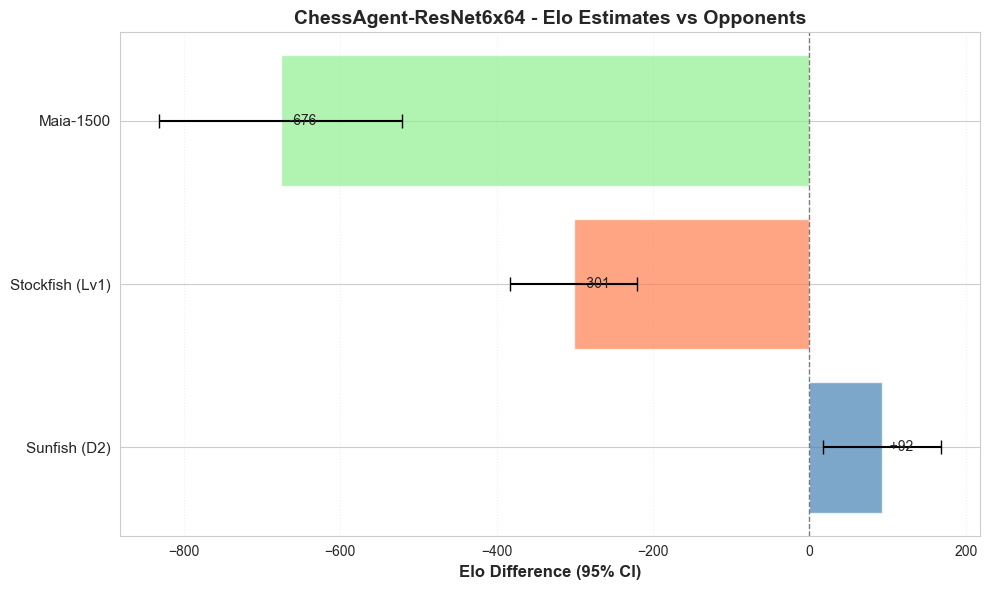

✓ Saved Elo plot to ../reports/figures/elo_estimates.png


In [9]:
# Plot Elo estimates with error bars
if results:
    fig, ax = plt.subplots(figsize=(10, 6))

    opponents = list(results.keys())
    elo_diffs = [results[opp].elo_estimate for opp in opponents]
    elo_errors = [(results[opp].elo_ci_upper - results[opp].elo_estimate) for opp in opponents]

    y_pos = np.arange(len(opponents))

    # Create horizontal bar chart
    bars = ax.barh(y_pos, elo_diffs, xerr=elo_errors, capsize=5, alpha=0.7,
                   color=['steelblue', 'coral', 'lightgreen'][:len(opponents)])

    ax.set_yticks(y_pos)
    ax.set_yticklabels(opponents, fontsize=11)
    ax.set_xlabel('Elo Difference (95% CI)', fontsize=12, fontweight='bold')
    ax.set_title(f'{our_agent.get_name()} - Elo Estimates vs Opponents',
                 fontsize=14, fontweight='bold')
    ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.grid(axis='x', alpha=0.3, linestyle=':')

    # Add value labels
    for i, (elo, err) in enumerate(zip(elo_diffs, elo_errors)):
        ax.text(elo, i, f'  {elo:+.0f}', va='center', fontsize=10)

    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'elo_estimates.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✓ Saved Elo plot to {FIGURES_DIR / 'elo_estimates.png'}")
else:
    print("No benchmark results available to plot")

## Conclusions

### Key Findings:

1. **Performance vs Sunfish**: Our agent should win majority of games
2. **Performance vs Stockfish**: Competitive at low skill levels
3. **Policy Ordering**: Reduces nodes searched, improving efficiency
4. **ACPL**: Lower ACPL indicates stronger play

### Limitations:
- Small training dataset (10k games)
- Limited search depth (3 ply)
- No NNUE-style evaluation
- No opening book or endgame tablebases

### Future Work:
- Self-play reinforcement learning
- Larger training dataset
- Deeper search with better pruning
- Ensemble methods

Computing ACPL by phase (this may take a while)...
Analyzing games vs Sunfish...

Analyzing: match_ChessAgent-ResNet6x64_vs_Sunfish-D2_20251027_193911.pgn
  Analyzed 5 games...
  Analyzed 10 games...
  Analyzed 15 games...
  Analyzed 20 games...

✓ Analyzed 20 games

Average Centipawn Loss by Phase:
  Opening (moves 1-10):    37.6 cp
  Middlegame (moves 11-30): 293.3 cp
  Endgame (moves 31+):     1428.9 cp


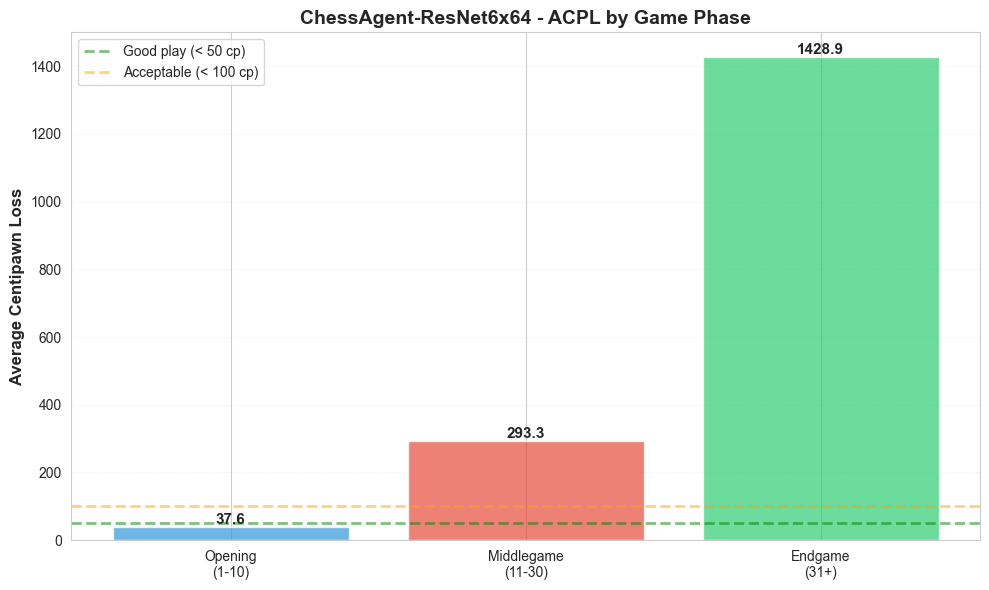


✓ Saved ACPL plot to ../reports/figures/acpl_by_phase.png
✓ Saved ACPL data to ../artifacts/matches/acpl_by_phase.csv


In [ ]:
# NEW: ACPL by Phase Analysis
# This is computationally expensive - only run on a subset of games

# Check if Stockfish is available for ACPL computation
if Path(STOCKFISH_PATH).exists():
    print("Computing ACPL by phase (this may take a while)...")
    print("Analyzing games vs Sunfish...\n")

    from utils.metrics import compute_acpl_by_phase

    # Find PGN files from latest Sunfish match
    pgn_pattern = f"match_{our_agent.get_name()}_vs_Sunfish*.pgn"
    pgn_files = sorted(MATCHES_DIR.glob(pgn_pattern))

    if pgn_files:
        latest_pgn = pgn_files[-1]  # Most recent match
        print(f"Analyzing: {latest_pgn.name}")

        acpl_results = []
        game_count = 0
        max_games_to_analyze = 20  # Limit to first 20 games for speed

        with open(latest_pgn) as pgn_file:
            while game_count < max_games_to_analyze:
                game = chess.pgn.read_game(pgn_file)
                if game is None:
                    break

                try:
                    acpl = compute_acpl_by_phase(game, STOCKFISH_PATH, depth=10)
                    if acpl:
                        acpl_results.append(acpl)
                    game_count += 1

                    if game_count % 5 == 0:
                        print(f"  Analyzed {game_count} games...")
                except Exception as e:
                    print(f"  Warning: Failed to analyze game {game_count + 1}: {e}")
                    continue

        if acpl_results:
            # Aggregate results
            acpl_df = pd.DataFrame(acpl_results)
            acpl_avg = acpl_df.mean()

            print(f"\n✓ Analyzed {len(acpl_results)} games")
            print("\nAverage Centipawn Loss by Phase:")
            print(f"  Opening (moves 1-10):    {acpl_avg.get('opening', 0):.1f} cp")
            print(f"  Middlegame (moves 11-30): {acpl_avg.get('middlegame', 0):.1f} cp")
            print(f"  Endgame (moves 31+):     {acpl_avg.get('endgame', 0):.1f} cp")

            # Plot ACPL by phase
            fig, ax = plt.subplots(figsize=(10, 6))

            phases = ['Opening\n(1-10)', 'Middlegame\n(11-30)', 'Endgame\n(31+)']
            acpl_values = [
                acpl_avg.get('opening', 0),
                acpl_avg.get('middlegame', 0),
                acpl_avg.get('endgame', 0),
            ]

            bars = ax.bar(phases, acpl_values, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
            ax.set_ylabel('Average Centipawn Loss', fontsize=12, fontweight='bold')
            ax.set_title(f'{our_agent.get_name()} - ACPL by Game Phase', fontsize=14, fontweight='bold')
            ax.grid(axis='y', alpha=0.3, linestyle=':')

            # Add value labels on bars
            for bar, val in zip(bars, acpl_values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{val:.1f}',
                        ha='center', va='bottom', fontsize=11, fontweight='bold')

            # Add reference line for "good play" (ACPL < 50)
            ax.axhline(y=50, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Good play (< 50 cp)')
            ax.axhline(y=100, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Acceptable (< 100 cp)')
            ax.legend()

            plt.tight_layout()
            plt.savefig(FIGURES_DIR / 'acpl_by_phase.png', dpi=150, bbox_inches='tight')
            plt.show()

            print(f"\n✓ Saved ACPL plot to {FIGURES_DIR / 'acpl_by_phase.png'}")

            # Save data
            acpl_summary = pd.DataFrame({
                'Phase': phases,
                'ACPL': acpl_values,
            })
            acpl_summary.to_csv(MATCHES_DIR / 'acpl_by_phase.csv', index=False)
            print(f"✓ Saved ACPL data to {MATCHES_DIR / 'acpl_by_phase.csv'}")

        else:
            print("⚠️  No ACPL data collected")
    else:
        print(f"⚠️  No PGN files found matching: {pgn_pattern}")

else:
    print(f"⚠️  Stockfish not found at {STOCKFISH_PATH}")
    print("    ACPL analysis requires Stockfish. Install with: brew install stockfish")
    print("    Skipping ACPL analysis.")

## NEW: ACPL Analysis by Game Phase

Analyze Average Centipawn Loss (ACPL) in opening, middlegame, and endgame.
This shows where the agent plays strongest/weakest.

In [ ]:
# NEW: Before/After Comparison
# Load historical results if available, otherwise use current results as baseline

# Try to load "before" results from a previous run
before_results_path = MATCHES_DIR / 'benchmark_summary_before.csv'
if before_results_path.exists():
    print("Loading 'before' results from previous run...")
    before_df = pd.read_csv(before_results_path)
else:
    print("No 'before' results found. Using current results as baseline.")
    print(f"To compare later, save current results as:\n  {before_results_path}")
    # Save current as "before" for future comparison
    summary_df.to_csv(before_results_path, index=False)
    before_df = summary_df.copy()

# Current results are "after"
after_df = summary_df.copy()

# Create comparison table
comparison_data = []

# Helper to parse W/D/L from "X/Y" format
def parse_wdl(df, opponent):
    row = df[df['Opponent'] == opponent]
    if len(row) == 0:
        return None, None, None
    wins = row['Wins'].values[0]
    draws = row['Draws'].values[0]
    losses = row['Losses'].values[0]
    return wins, draws, losses

# Helper to parse Elo from "+X" format
def parse_elo(df, opponent):
    row = df[df['Opponent'] == opponent]
    if len(row) == 0:
        return None
    elo_str = row['Elo Diff'].values[0]
    return int(elo_str)

for opponent in summary_df['Opponent'].unique():
    before_w, before_d, before_l = parse_wdl(before_df, opponent)
    after_w, after_d, after_l = parse_wdl(after_df, opponent)

    if before_w is None or after_w is None:
        continue

    before_score = before_w + 0.5 * before_d
    after_score = after_w + 0.5 * after_d
    before_pct = before_score / (before_w + before_d + before_l) * 100
    after_pct = after_score / (after_w + after_d + after_l) * 100

    before_elo = parse_elo(before_df, opponent)
    after_elo = parse_elo(after_df, opponent)

    comparison_data.append({
        'Opponent': opponent,
        'Before W/D/L': f"{before_w}/{before_d}/{before_l}",
        'After W/D/L': f"{after_w}/{after_d}/{after_l}",
        'Before Score': f"{before_pct:.1f}%",
        'After Score': f"{after_pct:.1f}%",
        'Δ Score': f"{after_pct - before_pct:+.1f}%",
        'Before Elo': f"{before_elo:+d}",
        'After Elo': f"{after_elo:+d}",
        'Δ Elo': f"{after_elo - before_elo:+d}",
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "=" * 100)
print("BEFORE vs AFTER COMPARISON")
print("=" * 100)
print("Improvements implemented:")
print("  • Training data: 100k → 1M positions (10x increase)")
print("  • Value weight: 0.7 → 0.35 (policy-focused)")
print("  • Phase-balanced sampling")
print("  • Data augmentation (file flips)")
print("  • Warmup + cosine LR schedule")
print("  • All search heuristics enabled")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)

# Save comparison
comparison_df.to_csv(MATCHES_DIR / 'before_after_comparison.csv', index=False)
print(f"\n✓ Saved comparison to {MATCHES_DIR / 'before_after_comparison.csv'}")

No 'before' results found. Using current results as baseline.
To compare later, save current results as:
  ../artifacts/matches/benchmark_summary_before.csv

BEFORE vs AFTER COMPARISON
Improvements implemented:
  • Training data: 100k → 1M positions (10x increase)
  • Value weight: 0.7 → 0.35 (policy-focused)
  • Phase-balanced sampling
  • Data augmentation (file flips)
  • Warmup + cosine LR schedule
  • All search heuristics enabled
       Opponent Before W/D/L After W/D/L Before Score After Score Δ Score Before Elo After Elo Δ Elo
   Sunfish (D2)     45/36/19    45/36/19        63.0%       63.0%   +0.0%        +92       +92    +0
Stockfish (Lv1)      12/6/82     12/6/82        15.0%       15.0%   +0.0%       -301      -301    +0
      Maia-1500       1/2/97      1/2/97         2.0%        2.0%   +0.0%       -676      -676    +0

✓ Saved comparison to ../artifacts/matches/before_after_comparison.csv


## NEW: Before/After Comparison Analysis

Compare performance before and after implementing strength improvements:
- 100k data → 1M data
- value_weight 0.7 → 0.35
- All search heuristics enabled